# 모델 불러와서 t-SNE로 점들 흩뿌려보자

In [16]:
from sklearn.manifold import TSNE
import torch
from torch.utils.data import SubsetRandomSampler, DataLoader, RandomSampler
import torchvision
from torchvision import datasets, transforms
import os
from inclearn.lib import data, factory, losses, network, utils
import clip
import numpy as np
from PIL import Image
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from inclearn.lib.network import OrthogonalNet, OrthogonalNet2

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# base_path = 'results/pretrained/20230611-0026_full_inc10_ep20_lr0.01_wd0.01-ft_ep20_lr0.05-k5'
base_path = 'results/pretrained2/20230612-0543_full2_inc10_ep20_lr0.01_wd0.01-ft_ep20_lr0.05-k5'

Using cuda:0 device


In [ ]:
saved_pth = base_path + '/net_0_task_0.pth'

model = OrthogonalNet(
    backbone_name='ViT-B/32',
    k_orth=5,
    postprocessor_kwargs={
        'type':'learned_scaling',
        'initial_value':1.0,
    }
)
model.add_classes(50)
model.load_state_dict(torch.load(saved_pth))

model.train_dummy()
model.eval()
model.to(device)
print()

In [1]:
def get_feature_tsne_each(model, n_classes=10):
    n_samples = 100

    class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
    out_dim = model.out_dim
    preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            transforms.Resize(224, interpolation=BICUBIC),
            transforms.CenterCrop(size=(224, 224)),
        ])

    cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
    cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

    train_list = torch.load('./exps/zero_train/train_list.pth')
    test_list = torch.load('./exps/zero_train/test_list.pth')

    print("Obtaining features")
    features = []
    labels = []
    for i, class_idx in enumerate(class_order):
        if i >= n_classes :
            break
        class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                                sampler=SubsetRandomSampler(test_list[class_idx]))
        with torch.no_grad():
            for X, y in class_loader:
                X = X.to(device)
                features.append(model(X)["features"].cpu().numpy())
                labels.append(y.cpu().numpy())
                break

            torch.cuda.empty_cache()

    features = np.array(features).reshape(-1,512)
    labels = np.array(labels).reshape(-1)
    labels = np.array([class_order.index(i) for i in labels])

    labels_group = labels // 10

    features_embedded = TSNE(n_components=2, random_state=0).fit_transform(features)
    class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

    plt.figure()
    plt.rc('font', size=10)
    for i in range(n_classes):
        idx = np.where(labels == i)
        plt.scatter(features_embedded[idx, 0], features_embedded[idx, 1], marker='.', label=i)
    plt.legend(loc='lower right')
    plt.show()

Features dimension is 512.
Obtaining features


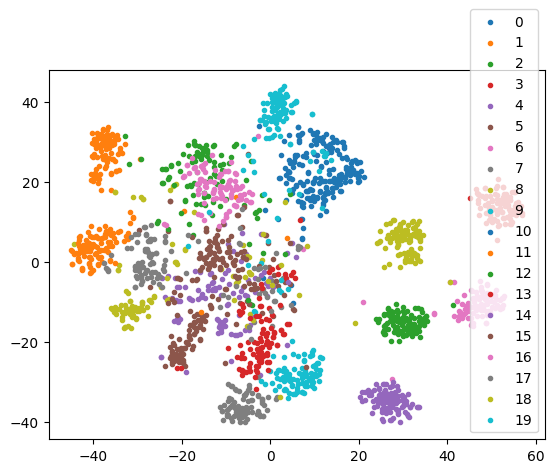

In [22]:
saved_pth = base_path + '/net_0_task_0.pth'

model = OrthogonalNet(
    backbone_name='ViT-B/32',
    k_orth=5,
    postprocessor_kwargs={
        'type':'learned_scaling',
        'initial_value':1.0,
    }
)
model.add_classes(50)
model.load_state_dict(torch.load(saved_pth))

model.train_dummy()
model.eval()
model.to(device)

get_feature_tsne_each(model, n_classes=20)

Features dimension is 512.
Obtaining features


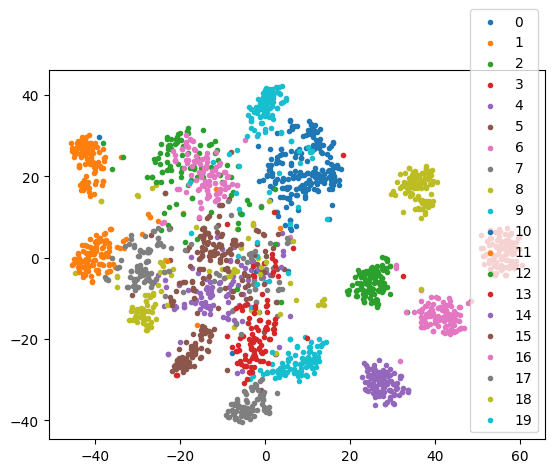

In [23]:
saved_pth = base_path + '/net_0_task_0.pth'

model = OrthogonalNet(
    backbone_name='ViT-B/32',
    k_orth=5,
    postprocessor_kwargs={
        'type':'learned_scaling',
        'initial_value':1.0,
    }
)
model.add_classes(50)
model.load_state_dict(torch.load(saved_pth))

model.train_classifier()
model.eval()
model.to(device)

get_feature_tsne_each(model, n_classes=20)

In [5]:
def get_feature_tsne(model, n_classes=5):
    n_samples = 100
    class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
    out_dim = model.out_dim
    preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            transforms.Resize(224, interpolation=BICUBIC),
            transforms.CenterCrop(size=(224, 224)),
        ])

    cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
    cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

    train_list = torch.load('./exps/zero_train/train_list.pth')
    test_list = torch.load('./exps/zero_train/test_list.pth')

    features = []
    labels = []
    for i, class_idx in enumerate(class_order):
        if i >= n_classes * 10 :
            break
        class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                                sampler=SubsetRandomSampler(test_list[class_idx]))
        with torch.no_grad():
            for X, y in class_loader:
                X = X.to(device)
                features.append(model(X)["features"].cpu().numpy())
                labels.append(y.cpu().numpy())
                break

            torch.cuda.empty_cache()

    features = np.array(features).reshape(-1,512)
    labels = np.array(labels).reshape(-1)
    labels = np.array([class_order.index(i) for i in labels])
    labels_group = labels // 10
    
    features_embedded = TSNE(n_components=2, random_state=0).fit_transform(features)
    
    class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

    plt.figure()
    plt.rc('font', size=10)
    for i in range(n_classes):
        idx = np.where(labels_group == i)
        plt.scatter(features_embedded[idx, 0], features_embedded[idx, 1], marker='.', label=class_ids[i])
    plt.legend(loc='lower right')
    plt.show()

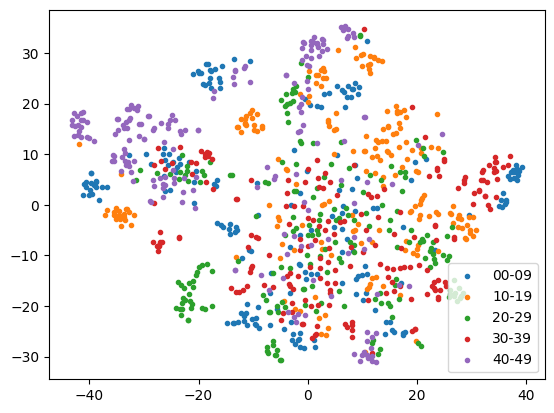

In [65]:
get_feature_tsne(model,5)

## 첫 task, no projection

Features dimension is 512.
Obtaining features


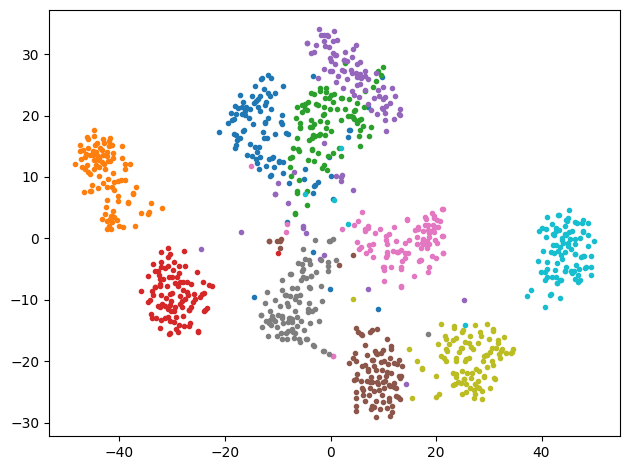

In [27]:
saved_pth = base_path + '/net_0_task_0.pth'

model = OrthogonalNet(
    backbone_name='ViT-B/32',
    k_orth=5,
    postprocessor_kwargs={
        'type':'learned_scaling',
        'initial_value':1.0,
    }
)
model.add_classes(50)
model.load_state_dict(torch.load(saved_pth))
model.train_dummy()
model.eval()
model.to(device)


n_classes = 50
k_class = 1


n_samples = 100

class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
out_dim = model.out_dim
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        transforms.Resize(224, interpolation=BICUBIC),
        transforms.CenterCrop(size=(224, 224)),
    ])

cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

train_list = torch.load('./exps/zero_train/train_list.pth')
test_list = torch.load('./exps/zero_train/test_list.pth')

print("Obtaining features")
features = []
labels = []
for i, class_idx in enumerate(class_order):
    if i >= n_classes :
        break
    elif i%10 > k_class:
        continue
    class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                            sampler=SubsetRandomSampler(test_list[class_idx]))
    with torch.no_grad():
        for X, y in class_loader:
            X = X.to(device)
            features.append(model(X)["features"].cpu().numpy())
            labels.append(y.cpu().numpy())
            break

        torch.cuda.empty_cache()

features = np.array(features).reshape(-1,512)
labels = np.array(labels).reshape(-1)
labels = np.array([class_order.index(i) for i in labels])

labels_group = labels // 10

features_embedded = TSNE(n_components=2, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

plt.figure()
plt.rc('font', size=10)
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    plt.scatter(features_embedded[idx, 0], features_embedded[idx, 1], marker='.', label=i)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("results/figs/init_noproj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

In [28]:
features_embedded = TSNE(n_components=3, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

plt.figure()
plt.rc('font', size=10)
ax = fig.add_subplot(projection='3d')
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], features_embedded[idx, 2], marker='.', label=i)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("results/figs/init_noproj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

<Figure size 640x480 with 0 Axes>

## 첫 task, orthogonal projection

Obtaining features


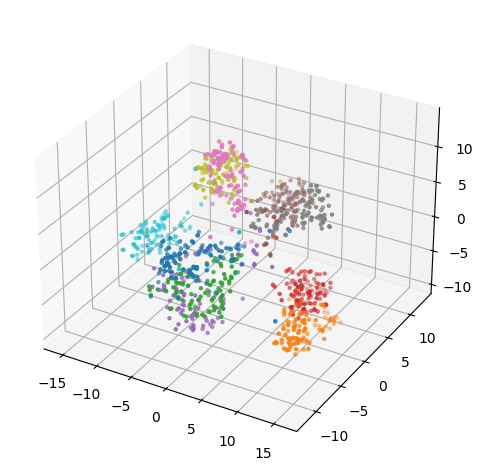

In [25]:
model.train_classifier()


n_classes = 50
k_class = 1


n_samples = 100

class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
out_dim = model.out_dim
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        transforms.Resize(224, interpolation=BICUBIC),
        transforms.CenterCrop(size=(224, 224)),
    ])

cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

train_list = torch.load('./exps/zero_train/train_list.pth')
test_list = torch.load('./exps/zero_train/test_list.pth')

print("Obtaining features")
features = []
labels = []
for i, class_idx in enumerate(class_order):
    if i >= n_classes :
        break
    elif i%10 > k_class:
        continue
    class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                            sampler=SubsetRandomSampler(test_list[class_idx]))
    with torch.no_grad():
        for X, y in class_loader:
            X = X.to(device)
            features.append(model(X)["features"].cpu().numpy())
            labels.append(y.cpu().numpy())
            break

        torch.cuda.empty_cache()

features = np.array(features).reshape(-1,512)
labels = np.array(labels).reshape(-1)
labels = np.array([class_order.index(i) for i in labels])

labels_group = labels // 10

features_embedded = TSNE(n_components=3, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

fig = plt.figure()
plt.rc('font', size=10)
ax = fig.add_subplot(projection='3d')
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], features_embedded[idx, 2], marker='.', label=i)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("results/figs/init_proj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

## 마지막 task, no projection

Obtaining features


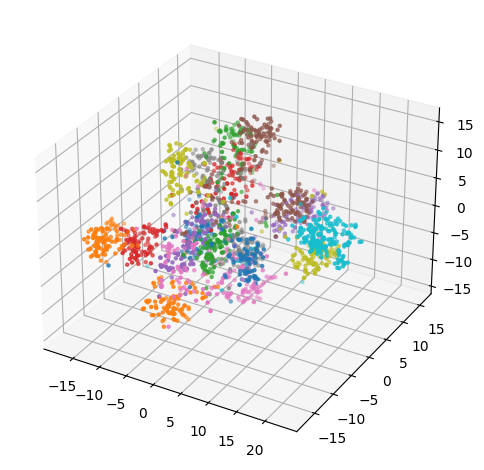

In [29]:
# saved_pth = base_path + '/net_0_task_5.pth'

# model = OrthogonalNet(
#     backbone_name='ViT-B/32',
#     k_orth=5,
#     postprocessor_kwargs={
#         'type':'learned_scaling',
#         'initial_value':1.0,
#     }
# )
# model.add_classes(50)
# model.add_classes(10)
# model.add_classes(10)
# model.add_classes(10)
# model.add_classes(10)
# model.add_classes(10)
# model.load_state_dict(torch.load(saved_pth))
model.train_dummy()
# model.eval()
# model.to(device)


n_classes = 100
k_class = 1


n_samples = 100

class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
out_dim = model.out_dim
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        transforms.Resize(224, interpolation=BICUBIC),
        transforms.CenterCrop(size=(224, 224)),
    ])

cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

train_list = torch.load('./exps/zero_train/train_list.pth')
test_list = torch.load('./exps/zero_train/test_list.pth')

print("Obtaining features")
features = []
labels = []
for i, class_idx in enumerate(class_order):
    if i >= n_classes :
        break
    elif i%10 > k_class:
        continue
    class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                            sampler=SubsetRandomSampler(test_list[class_idx]))
    with torch.no_grad():
        for X, y in class_loader:
            X = X.to(device)
            features.append(model(X)["features"].cpu().numpy())
            labels.append(y.cpu().numpy())
            break

        torch.cuda.empty_cache()

features = np.array(features).reshape(-1,512)
labels = np.array(labels).reshape(-1)
labels = np.array([class_order.index(i) for i in labels])

labels_group = labels // 10

features_embedded = TSNE(n_components=3, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

fig = plt.figure()
plt.rc('font', size=10)
ax = fig.add_subplot(projection='3d')
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], features_embedded[idx, 2], marker='.', label=i)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("results/figs/last_noproj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

## 마지막 task, orthogonal projection

Obtaining features


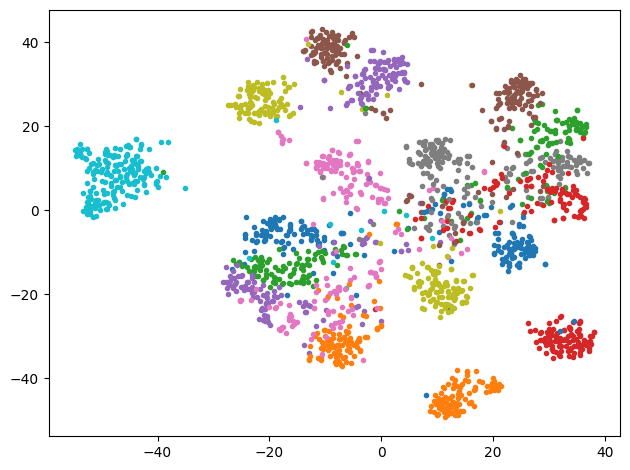

In [30]:
model.train_classifier()


n_classes = 100
k_class = 1


n_samples = 100

class_order = [87, 0, 52, 58, 44, 91, 68, 97, 51, 15, 94, 92, 10, 72, 49, 78, 61, 14, 8, 86, 84, 96, 18, 24, 32, 45, 88, 11, 4, 67, 69, 66, 77, 47, 79, 93, 29, 50, 57, 83, 17, 81, 41, 12, 37, 59, 25, 20, 80, 73, 1, 28, 6, 46, 62, 82, 53, 9, 31, 75, 38, 63, 33, 74, 27, 22, 36, 3, 16, 21, 60, 19, 70, 90, 89, 43, 5, 42, 65, 76, 40, 30, 23, 85, 2, 95, 56, 48, 71, 64, 98, 13, 99, 7, 34, 55, 54, 26, 35, 39]
out_dim = model.out_dim
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        transforms.Resize(224, interpolation=BICUBIC),
        transforms.CenterCrop(size=(224, 224)),
    ])

cifar100_train = torchvision.datasets.CIFAR100(root="./data", train=True, transform=preprocess)
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)

train_list = torch.load('./exps/zero_train/train_list.pth')
test_list = torch.load('./exps/zero_train/test_list.pth')

print("Obtaining features")
features = []
labels = []
for i, class_idx in enumerate(class_order):
    if i >= n_classes :
        break
    elif i%10 > k_class:
        continue
    class_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples, 
                            sampler=SubsetRandomSampler(test_list[class_idx]))
    with torch.no_grad():
        for X, y in class_loader:
            X = X.to(device)
            features.append(model(X)["features"].cpu().numpy())
            labels.append(y.cpu().numpy())
            break

        torch.cuda.empty_cache()

features = np.array(features).reshape(-1,512)
labels = np.array(labels).reshape(-1)
labels = np.array([class_order.index(i) for i in labels])

labels_group = labels // 10

features_embedded = TSNE(n_components=2, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

plt.figure()
plt.rc('font', size=10)
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    plt.scatter(features_embedded[idx, 0], features_embedded[idx, 1], marker='.', label=i)
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("results/figs/last_proj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

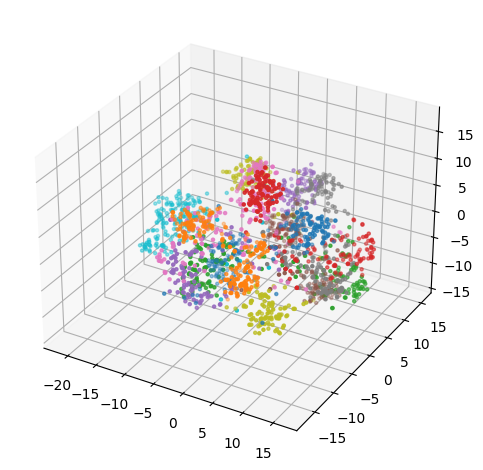

In [31]:
features_embedded = TSNE(n_components=3, random_state=0).fit_transform(features)
class_ids = ['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

fig = plt.figure()
plt.rc('font', size=10)
ax = fig.add_subplot(projection='3d')
for i in range(n_classes):
    if i%10 > k_class:
        continue
    idx = np.where(labels == i)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], features_embedded[idx, 2], marker='.', label=i)
plt.tight_layout()
plt.savefig("results/figs/last_proj.jpg", bbox_inches='tight', transparent=True, dpi=440)
plt.show()

# Orthogonal Validation Check

In [4]:
n_samples=100
preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            transforms.Resize(224, interpolation=BICUBIC),
            transforms.CenterCrop(size=(224, 224)),
        ])
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, transform=preprocess)
test_loader = DataLoader(cifar100_test, shuffle=False, batch_size=n_samples)

In [5]:
X,y = next(iter(test_loader))
X = X.to(device)

In [6]:
X.shape

torch.Size([100, 3, 224, 224])

In [7]:
y.shape

torch.Size([100])

In [8]:
# test init model
new_base_path = 'results/pretrained/20230612-0251_full_inc10_ep20_lr0.01_wd0.01-ft_ep20_lr0.05-k5'
saved_pth = new_base_path + '/net_0_task_0.pth'

model = OrthogonalNet(
    backbone_name='ViT-B/32',
    k_orth=5,
    postprocessor_kwargs={
        'type':'learned_scaling',
        'initial_value':1.0,
    }
)
model.add_classes(50)
model.load_state_dict(torch.load(saved_pth))
model.eval()
model.to(device)
print()

Features dimension is 512.



In [9]:
model.train_dummy()
original_feature = model(X)["features"]
print(original_feature)

tensor([[ 0.0540,  0.0152, -0.3154,  ...,  0.9409,  0.2893,  0.1364],
        [-0.3223, -0.1083, -0.2004,  ...,  1.0322, -0.2920, -0.0447],
        [ 0.6528,  0.2800, -0.2302,  ...,  0.8530,  0.0945, -0.0812],
        ...,
        [ 0.2423,  0.1486, -0.4219,  ...,  0.9414,  0.2871,  0.0054],
        [-0.0151,  0.1729,  0.0021,  ...,  0.8223,  0.1665, -0.1407],
        [ 0.0707,  0.0083, -0.3064,  ...,  1.0674, -0.0208,  0.0975]],
       device='cuda:0')


In [10]:
model.train_classifier()
original_feature = model(X)["features"]
print(original_feature)

tensor([[ 0.1320,  0.0338, -0.4606,  ...,  0.4020, -0.1464, -0.0980],
        [ 0.1120, -0.1939, -0.1885,  ...,  0.3791, -0.2508, -0.0674],
        [ 0.2433,  0.2374, -0.2405,  ...,  0.4323, -0.2502, -0.2009],
        ...,
        [ 0.3721,  0.1612, -0.3547,  ...,  0.3950,  0.0495, -0.2938],
        [ 0.0725,  0.0781, -0.1802,  ...,  0.4105, -0.1201, -0.2299],
        [ 0.1081, -0.0133, -0.3531,  ...,  0.4882, -0.2871, -0.1867]],
       device='cuda:0')


# Test

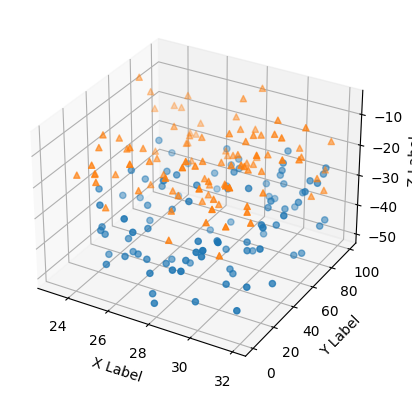

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()